In [20]:
cd ..

C:\Users\688228hh


In [21]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.5
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] - params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 0, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=1.5, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

0.15


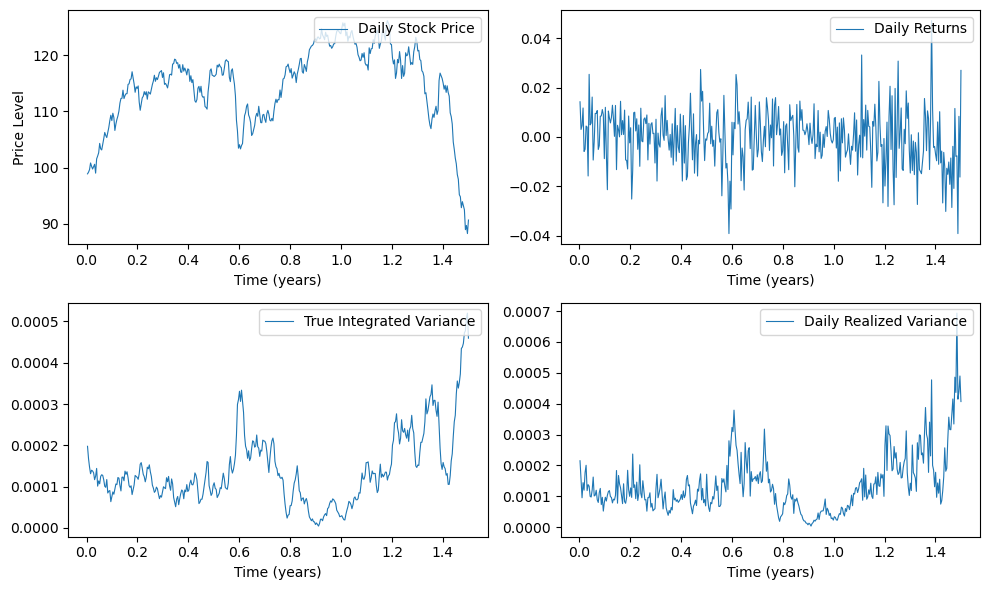

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [46]:
1.5*0.6

0.8999999999999999

In [47]:
burnin = 252
dt = 1  # Daily

split_index = round(0.9 * 252) 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [48]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
mu: 0.001000
sigma: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [0.001 0.001 0.001 0.001 0.001]


### Both - Corr

In [49]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.015000
theta: 0.000100
xi: 0.001000
mu: 0.001000
sigma: 0.001000
rho: -0.100000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 0.015   0.0001  0.001   0.001   0.001  -0.1   ]


### Return

In [50]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
mu: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.001 0.001 0.001 0.001]


### Return - Corr

In [51]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.002000
theta: 0.000100
xi: 0.007000
mu: 0.002000
rho: 0.000000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.002  0.0001 0.007  0.002  0.    ]


### RV

In [52]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
sigma: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.001 0.001 0.001 0.001]


### PF

In [53]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.2, 0.2),    # mu
    (1, 10),        # kappa
    (0.02, 0.1),    # theta
    (0.05, 0.8),    # xi
    (-1, 0),        # rho
    V0              # v0
]

V_pf_train, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
V_pf_train_daily = V_pf_train / 252

resampling since: 68.4769474519486
resampling since: 2410.7833909897913
resampling since: 2228.831770357087
resampling since: 488.2996351463047
resampling since: 3493.144624655295
resampling since: 3236.6807615113407
resampling since: 400.13688729592695
resampling since: 48.04268701853902
resampling since: 1927.4619112777407
resampling since: 3276.2673874108154
resampling since: 3271.687616280839
resampling since: 1025.4140694090609
resampling since: 2677.5373819236806
resampling since: 3080.0335167483
resampling since: 984.9270876188584
resampling since: 2625.189673950842
resampling since: 3212.1212528195233
resampling since: 2236.904857997588
resampling since: 1844.1878994901322
resampling since: 2860.800058736135
resampling since: 2605.006201460192
resampling since: 1241.2067603165262
resampling since: 3237.1178620033807
resampling since: 3279.190657457301
resampling since: 2927.354373747248
resampling since: 1922.7727050130673
resampling since: 3006.0912339243678
resampling since: 

In [54]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

param_bounds_test = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))
param_bounds_test.append(V_pf_train[-1])

V_pf_test, _ = pf_heston_test.filter(param_bounds_test, predict_obs=False)
V_pf_test_daily = V_pf_test / 252

resampling since: 3388.85287494513
resampling since: 2125.078018770476
resampling since: 3034.6534113493412
resampling since: 3361.851661759499
resampling since: 3289.7494923242903
resampling since: 3188.7909999542153
resampling since: 3188.5062822636337
resampling since: 2137.127650020625
resampling since: 2530.436732818806
resampling since: 3498.639353226419
resampling since: 3274.7552561261195
resampling since: 3479.415483188453
resampling since: 3445.0977613198106
resampling since: 3072.725090188848
resampling since: 2114.762484754979
resampling since: 481.6363144747931
resampling since: 1197.7213116034693
resampling since: 3095.650682628301
resampling since: 3365.0597652106358
resampling since: 3059.5731172930755
resampling since: 3250.5828276399316
resampling since: 2665.856440453955
resampling since: 3462.2392682557397
resampling since: 3446.8368661672375
resampling since: 3159.606671287466
resampling since: 2968.8132057497846
resampling since: 2217.9715925388837
resampling sinc

## Plot

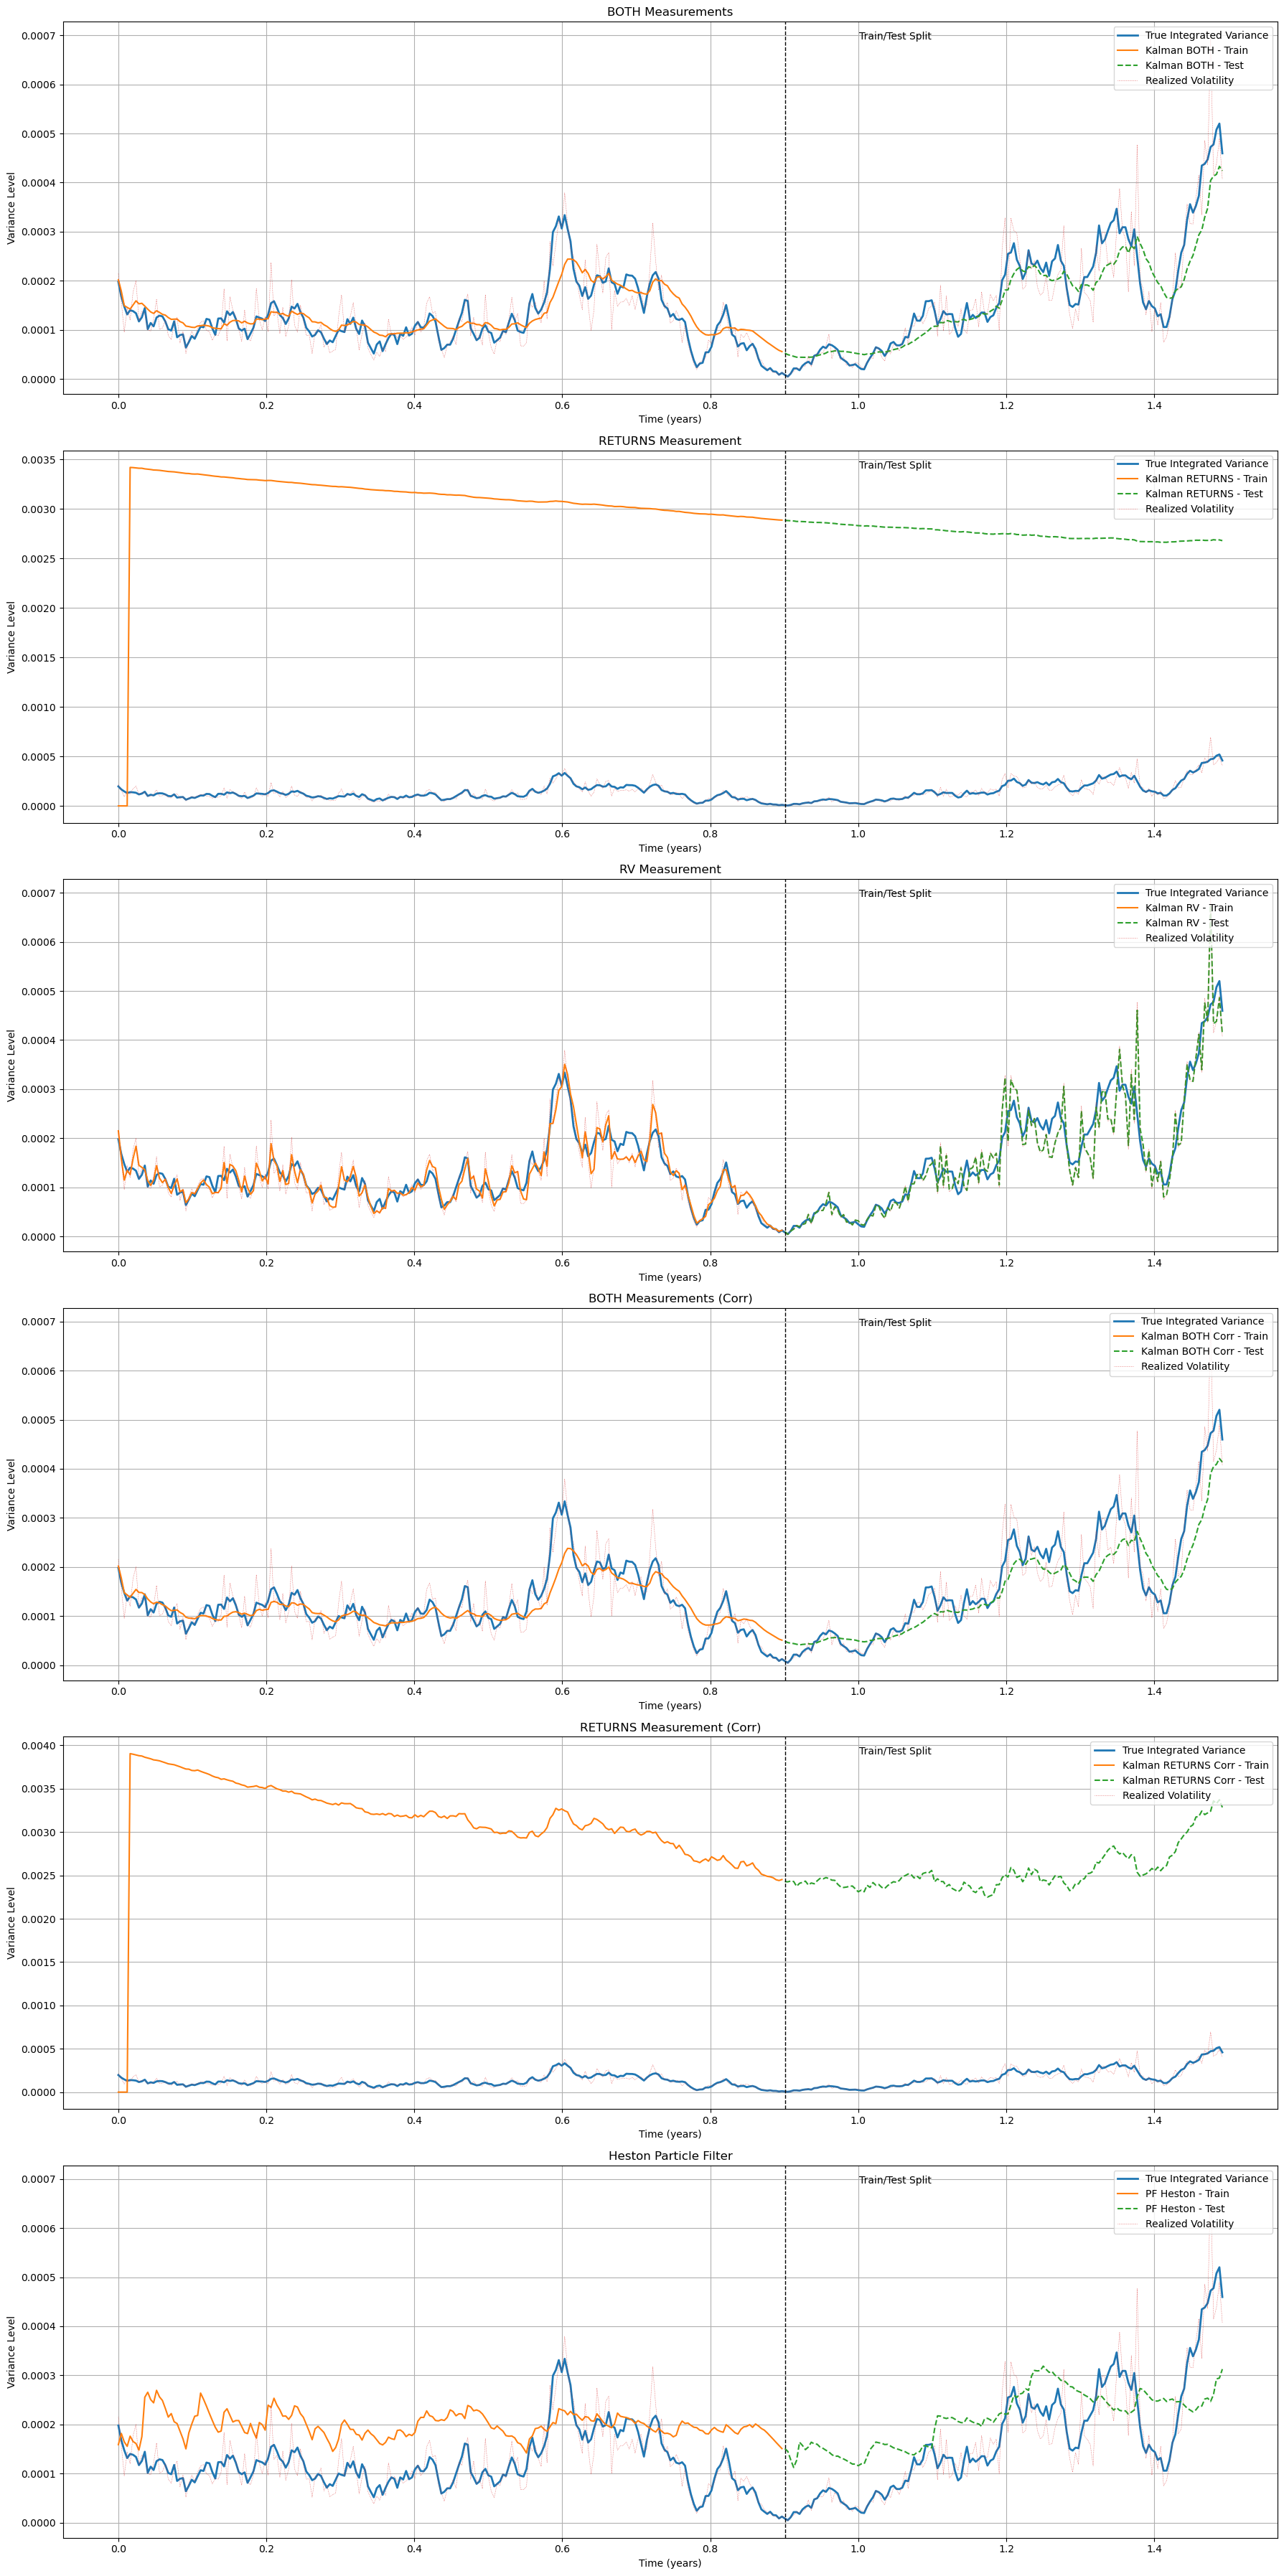

In [55]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt'], V_pf_train_daily]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr, V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0,
    save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\short_period.png"
)

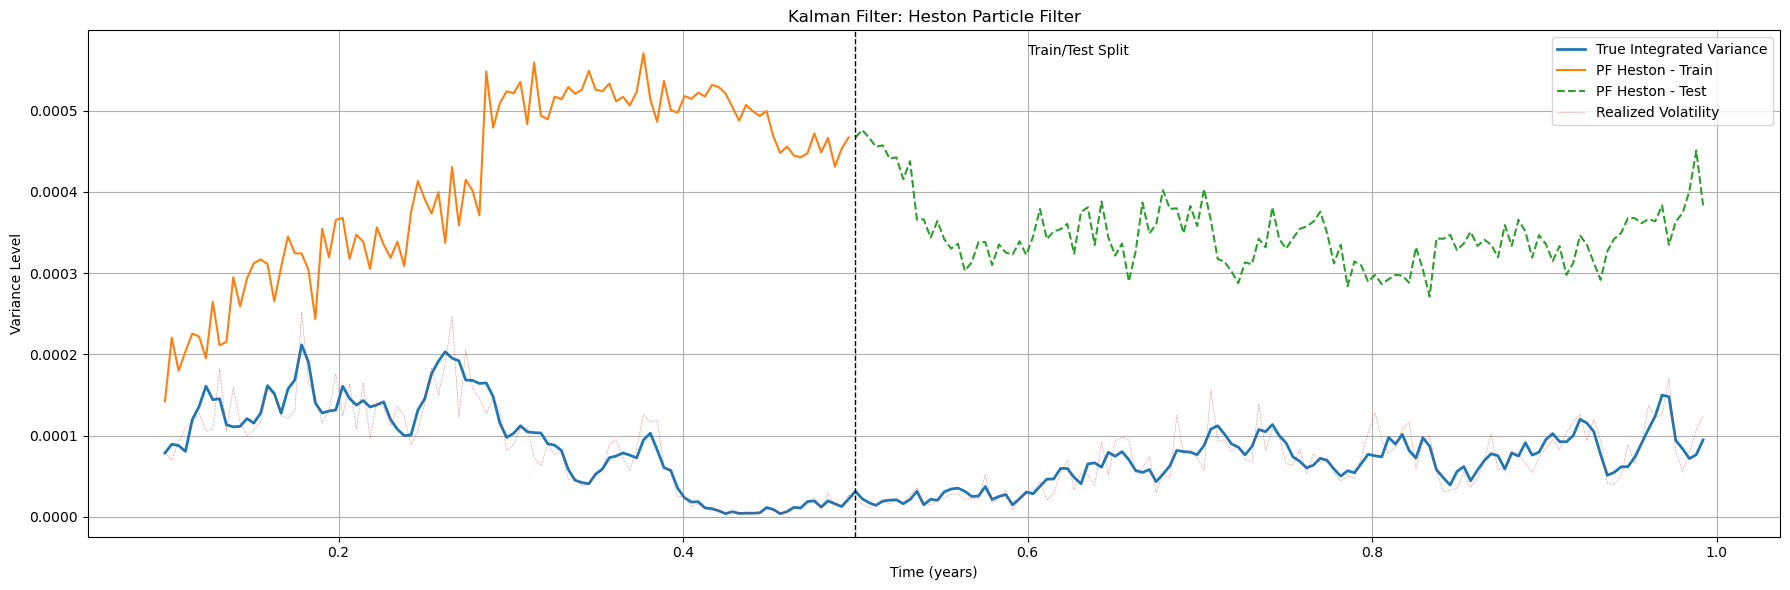

In-Sample RMSE (Heston Particle Filter): 0.000354
Out-of-Sample RMSE (Heston Particle Filter): 0.000288


(0.00035400553170681005, 0.0002880595744380567)

In [37]:
Utility.plot_filter_result(
    plot_index=5,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=25
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034
